# Supernova distances and redshifts (part 2)

In [1]:
import numpy as np
import pylab as plt
import scipy.stats

from astroML.datasets import generate_mu_z
from astropy.cosmology import FlatLambdaCDM

from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.model_selection import GridSearchCV

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

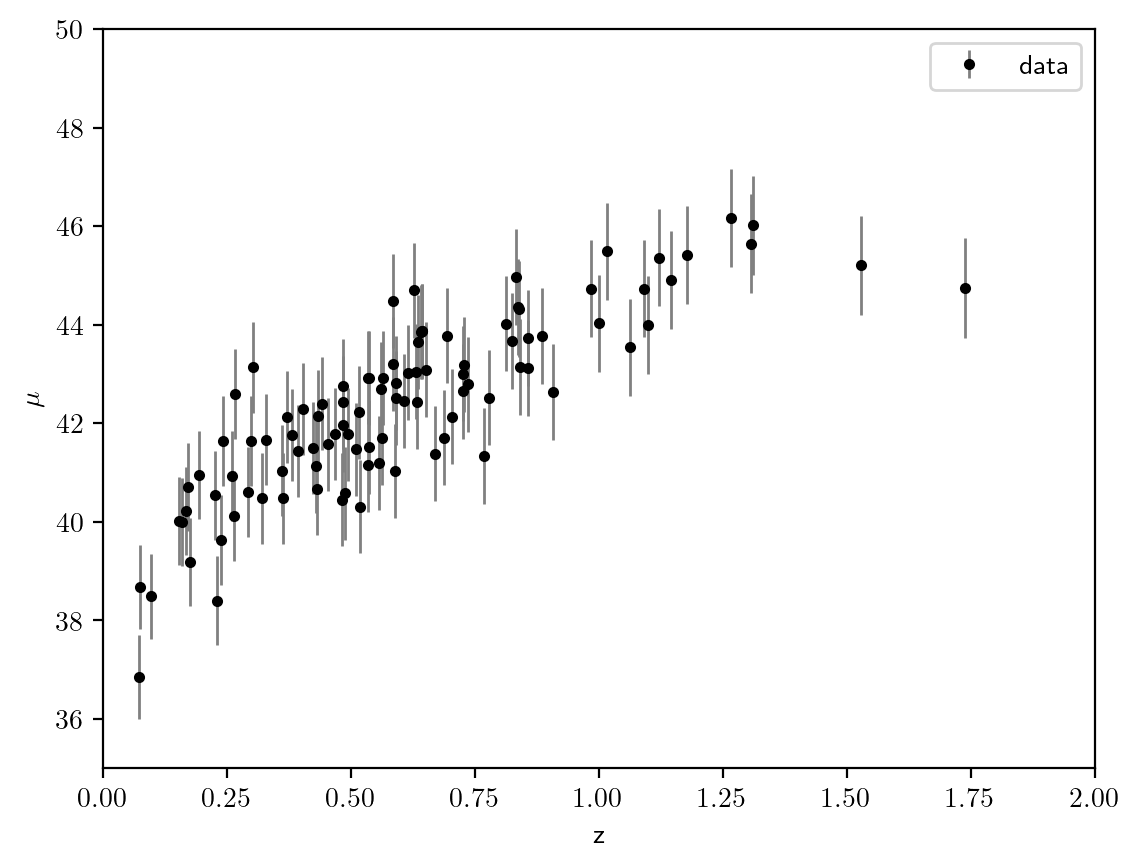

In [2]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

In [3]:
x = z_sample[:,np.newaxis]
y = mu_sample[:,np.newaxis]
dy = dmu[:,np.newaxis]

## GPR

In [4]:
kernel = 1.0 * kernels.RBF(1.0) # constant + rbf kernel
GPR = GaussianProcessRegressor(kernel=kernel, alpha=dmu ** 2, random_state=42)
GPR.fit(x, y)

x_grid = np.linspace(0, 2, 200)
f, f_err = GPR.predict(x_grid[:,np.newaxis], return_std=True)

print("Optimized kernel:", GPR.kernel_)
print("Amplitude:", np.exp(GPR.kernel_.theta[0]))      # associated to const kernel (vertical scale of the function) 
print("Length scale:", np.exp(GPR.kernel_.theta[1]))   # associated to RBF kernel (horizontal scale)

Optimized kernel: 30.7**2 * RBF(length_scale=3.9)
Amplitude: 941.4309603667124
Length scale: 3.8984532691993166


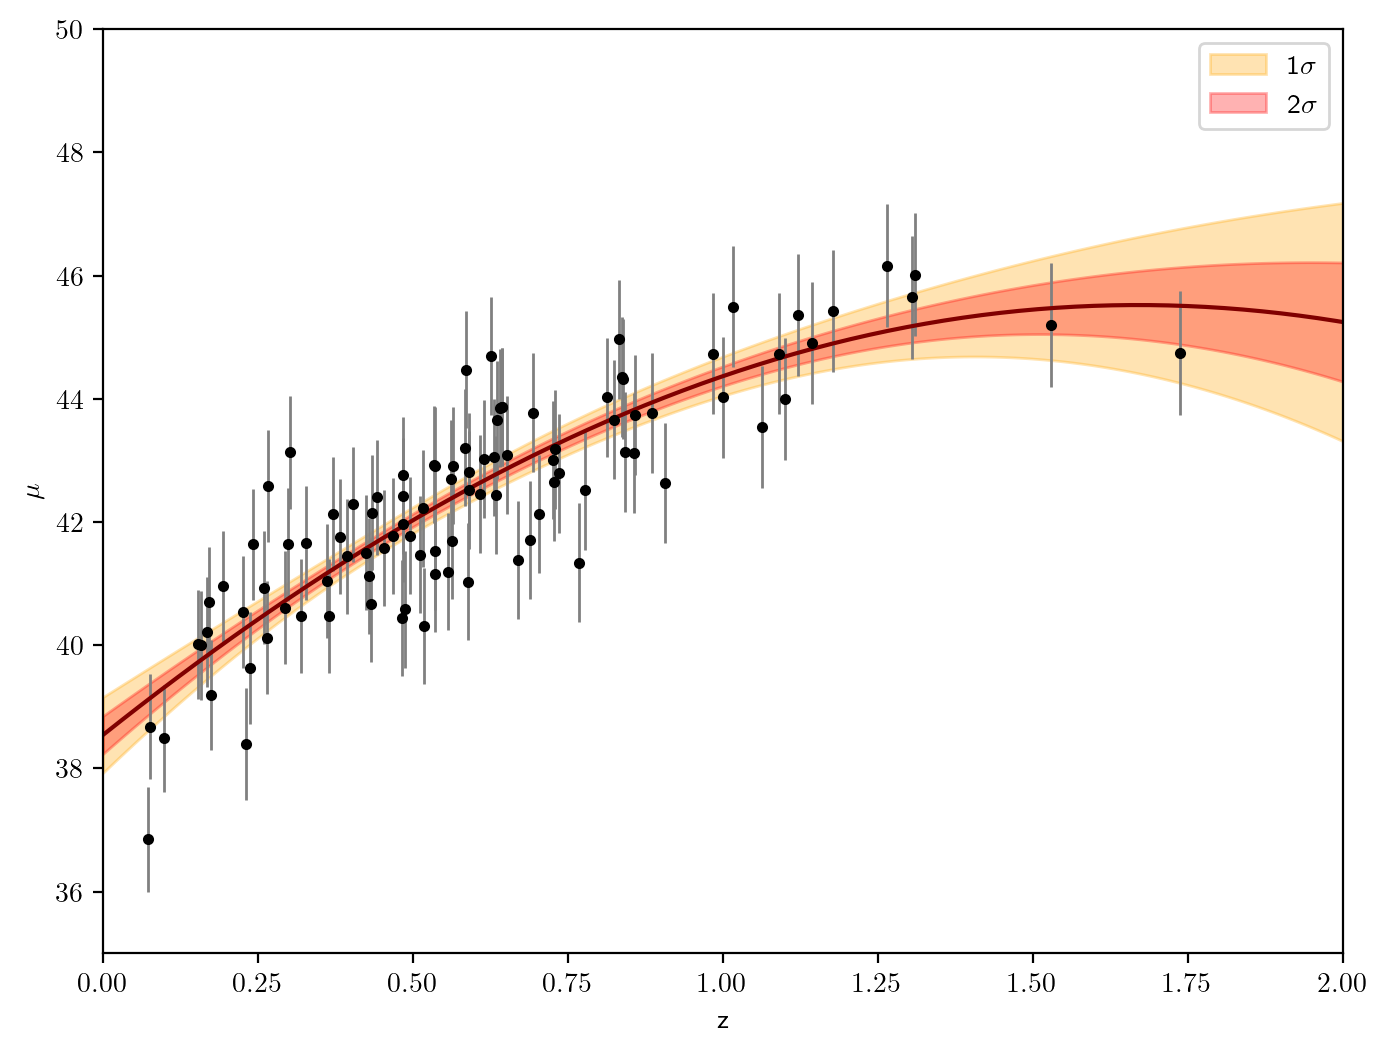

In [5]:
plt.figure(figsize=(8,6))
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(x_grid,f, color='maroon')
plt.fill_between(x_grid, f - 2 * f_err, f + 2 * f_err, color='orange', alpha=0.3, label=r'1$\sigma$')
plt.fill_between(x_grid, f - 1 * f_err, f + 1 * f_err, color='red', alpha=0.3, label=r'2$\sigma$')

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend(loc='best')
plt.show()

Optimize hyperparameters.

In [6]:
kernel = 1.0 * kernels.RBF(1.0)

GPR = GaussianProcessRegressor(kernel=kernel, random_state=42)

# Define parameter grid
param_grid = {
    "kernel__k1__constant_value": np.logspace(-5, 5, 10),          # Amplitude
    "kernel__k1__constant_value_bounds": [(1e-5, 1e5)],
    "kernel__k2__length_scale": np.logspace(-5, 5, 10),          # Length Scale
    "kernel__k2__length_scale_bounds": [(1e-5, 1e5)],
    "alpha": [1e-2, 1e-1, 1, 10]
}

grid_search = GridSearchCV(GPR, param_grid, cv=5)

grid_search.fit(x, y)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better v

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                                                random_state=42),
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'kernel__k1__constant_value': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'kernel__k1__constant_value_bounds': [(1e-05,
                                                                100000.0)],
                         'kernel__k2__length_scale': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                         'kernel__k2__length_scale_bounds': [(1e-05,
                                                              100000.0)]})

In [7]:
print("Best Parameters:", grid_search.best_params_)
print("Best Kernel:", grid_search.best_estimator_.kernel_)

Best Parameters: {'alpha': 0.1, 'kernel__k1__constant_value': 1e-05, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 599.4842503189421, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0)}
Best Kernel: 31.4**2 * RBF(length_scale=0.477)


## Parameter estimation

Predicted relationship between the distance module $\mu$ and the redshift $z$ (for flat universe):

$$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) $$

where $\Omega_\Lambda = 1-\Omega_m $.

In [8]:
def dist_module(z, H0, Om):
    lambda_CDM = FlatLambdaCDM(H0=H0, Om0=Om)
    return lambda_CDM.distmod(z).value  #only value, without units

In [9]:
def LogLikelihood(theta, z_sample, mu_sample, dmu):
    H0, Om = theta
    if Om > 0:
        mu_model = dist_module(z_sample, H0, Om)
        gauss = scipy.stats.norm(loc=mu_model, scale=dmu)
        return np.sum(gauss.logpdf(mu_sample))
    else:
        return -np.inf

In [10]:
def prior_transform(u):
    theta = np.zeros(len(u))
    theta_min = np.array([50, 0.1])
    theta_max = np.array([100, 1])

    theta[0] = scipy.stats.uniform(loc=theta_min[0], scale=theta_max[0]-theta_min[0]).ppf(u[0])
    theta[1] = scipy.stats.uniform(loc=theta_min[1], scale=theta_max[1]-theta_min[1]).ppf(u[1])
    
    return theta

In [11]:
ndim = 2             # number of parameters in the model

sampler = dynesty.NestedSampler(LogLikelihood, prior_transform, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=200)

sampler.run_nested()
sresults = sampler.results

771it [00:08, 90.96it/s, +200 | bound: 1 | nc: 1 | ncall: 7618 | eff(%): 13.090 | loglstar:   -inf < -132.814 <    inf | logz: -135.003 +/-  0.079 | dlogz:  0.001 >  0.209]


#### Runplot 

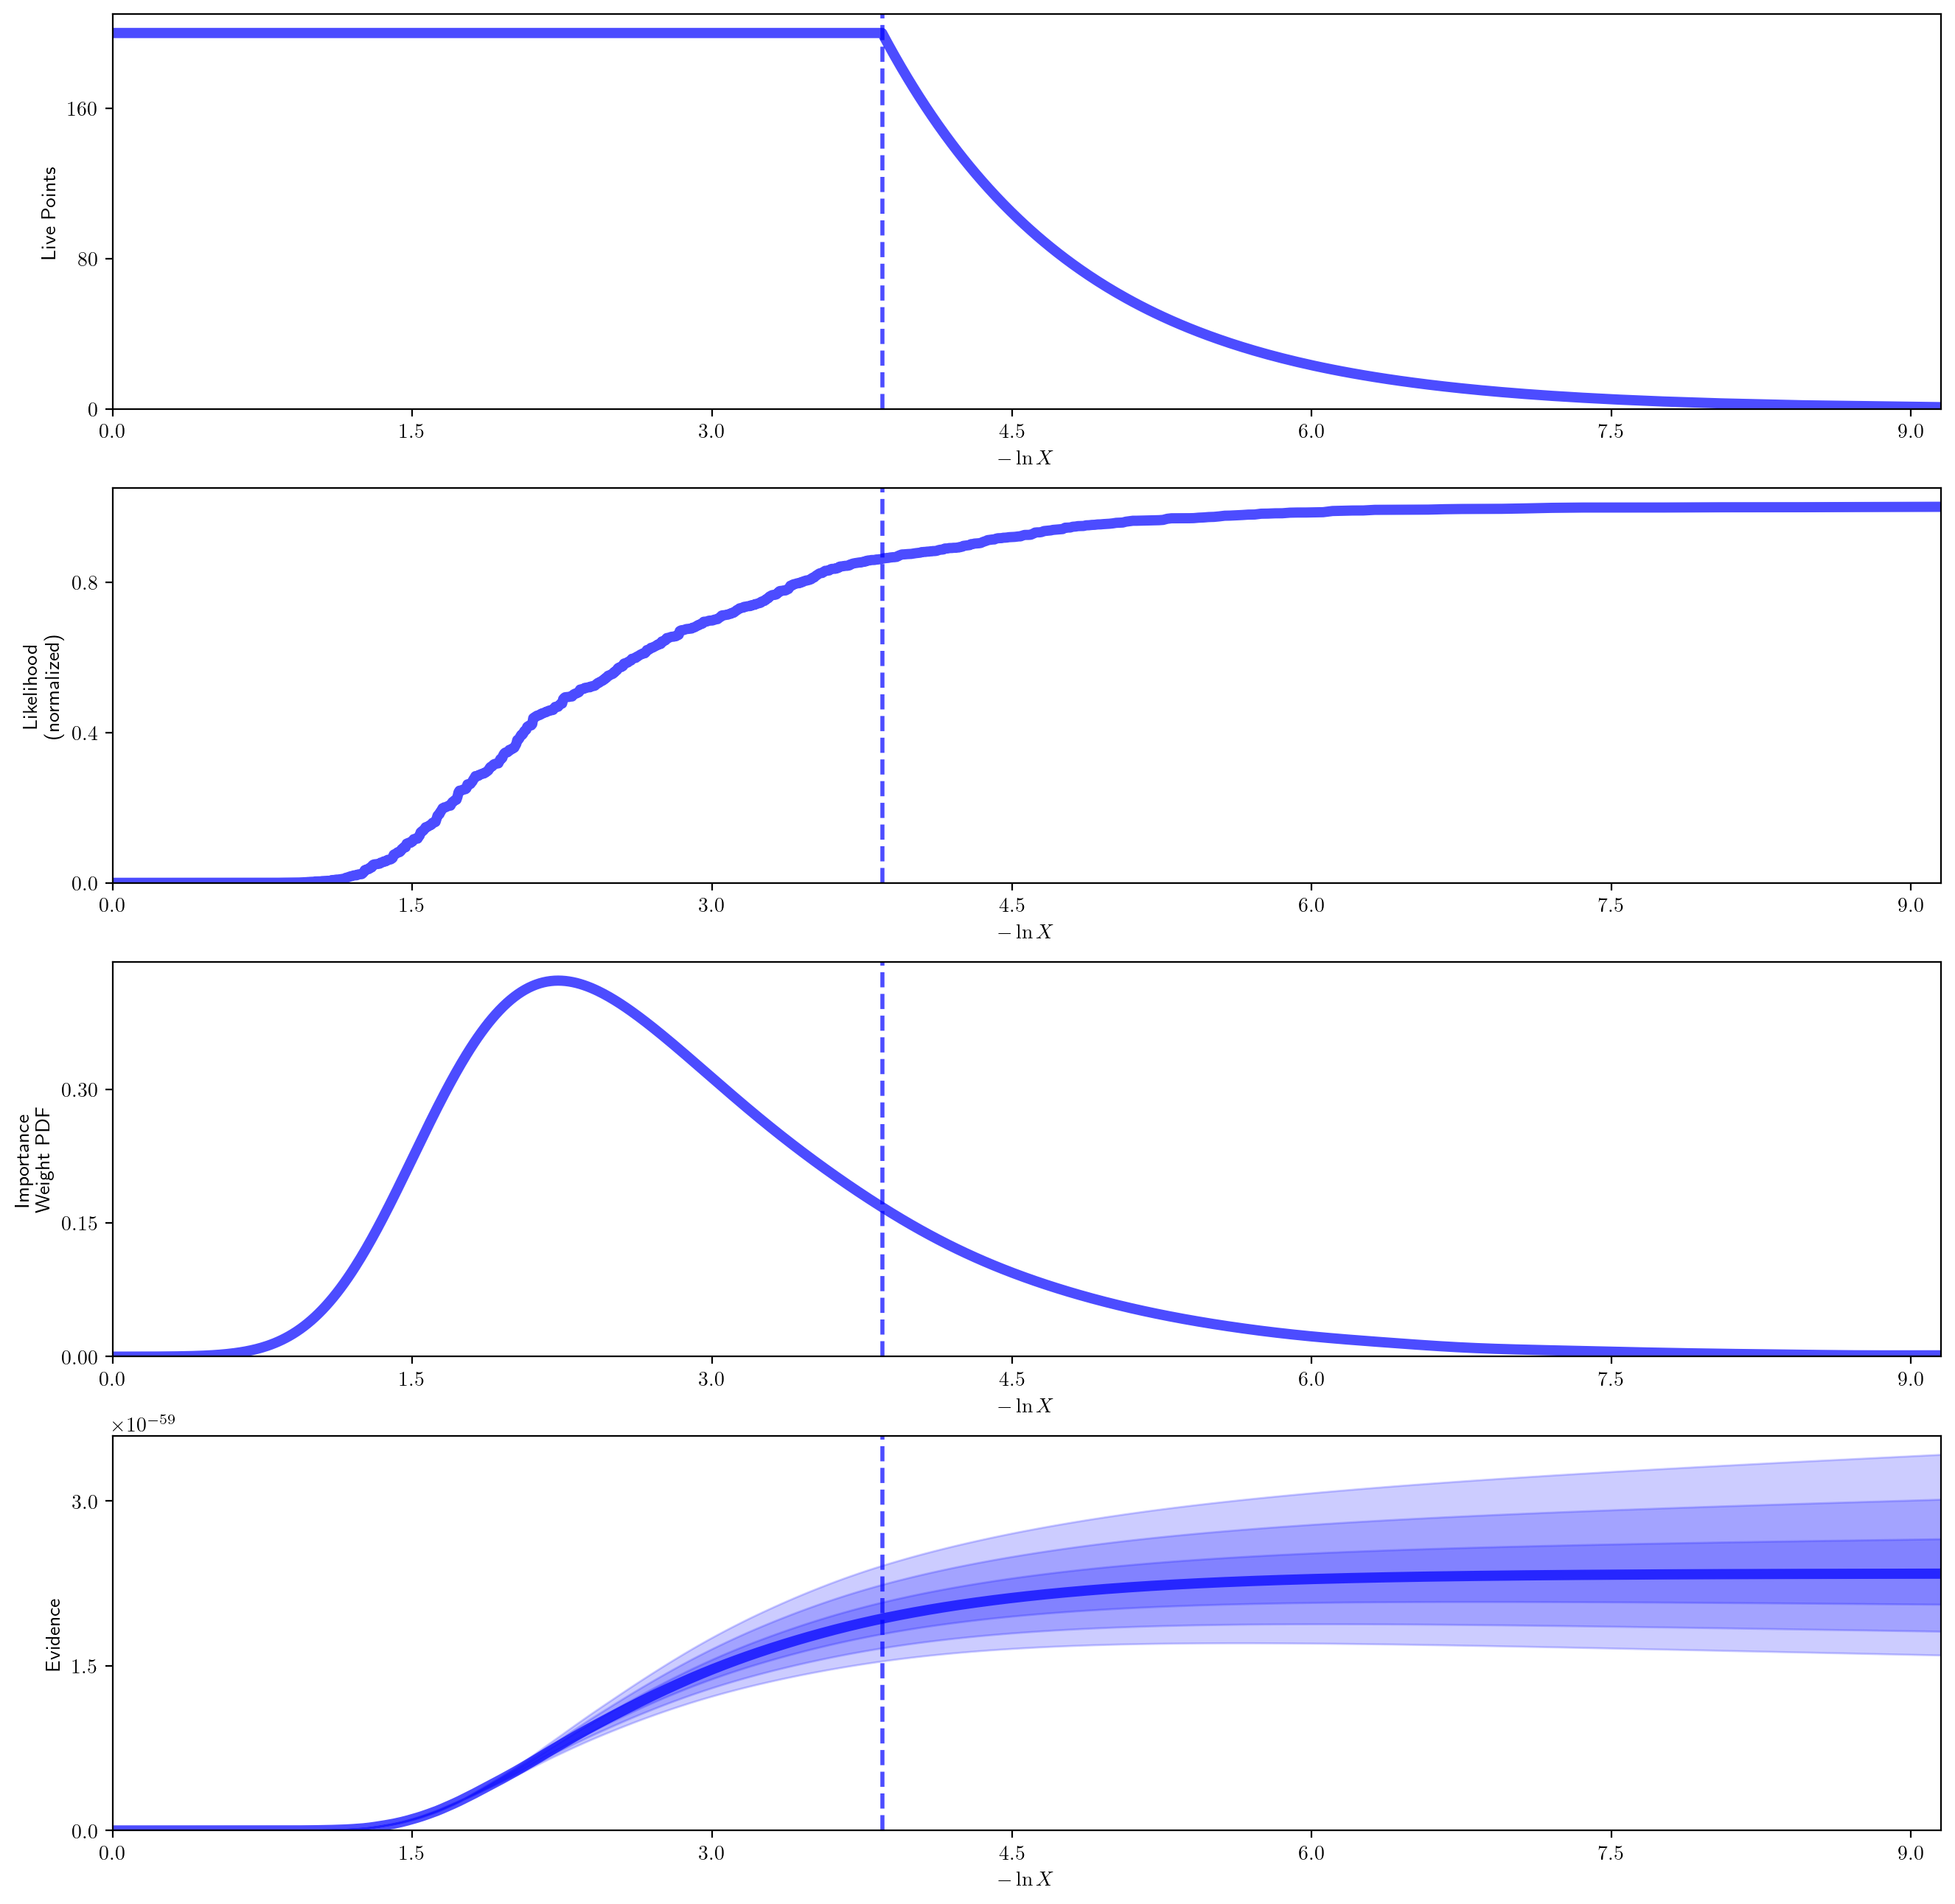

In [12]:
runplot_fig, runplot_axes = dyplot.runplot(sresults)

#### Traceplots

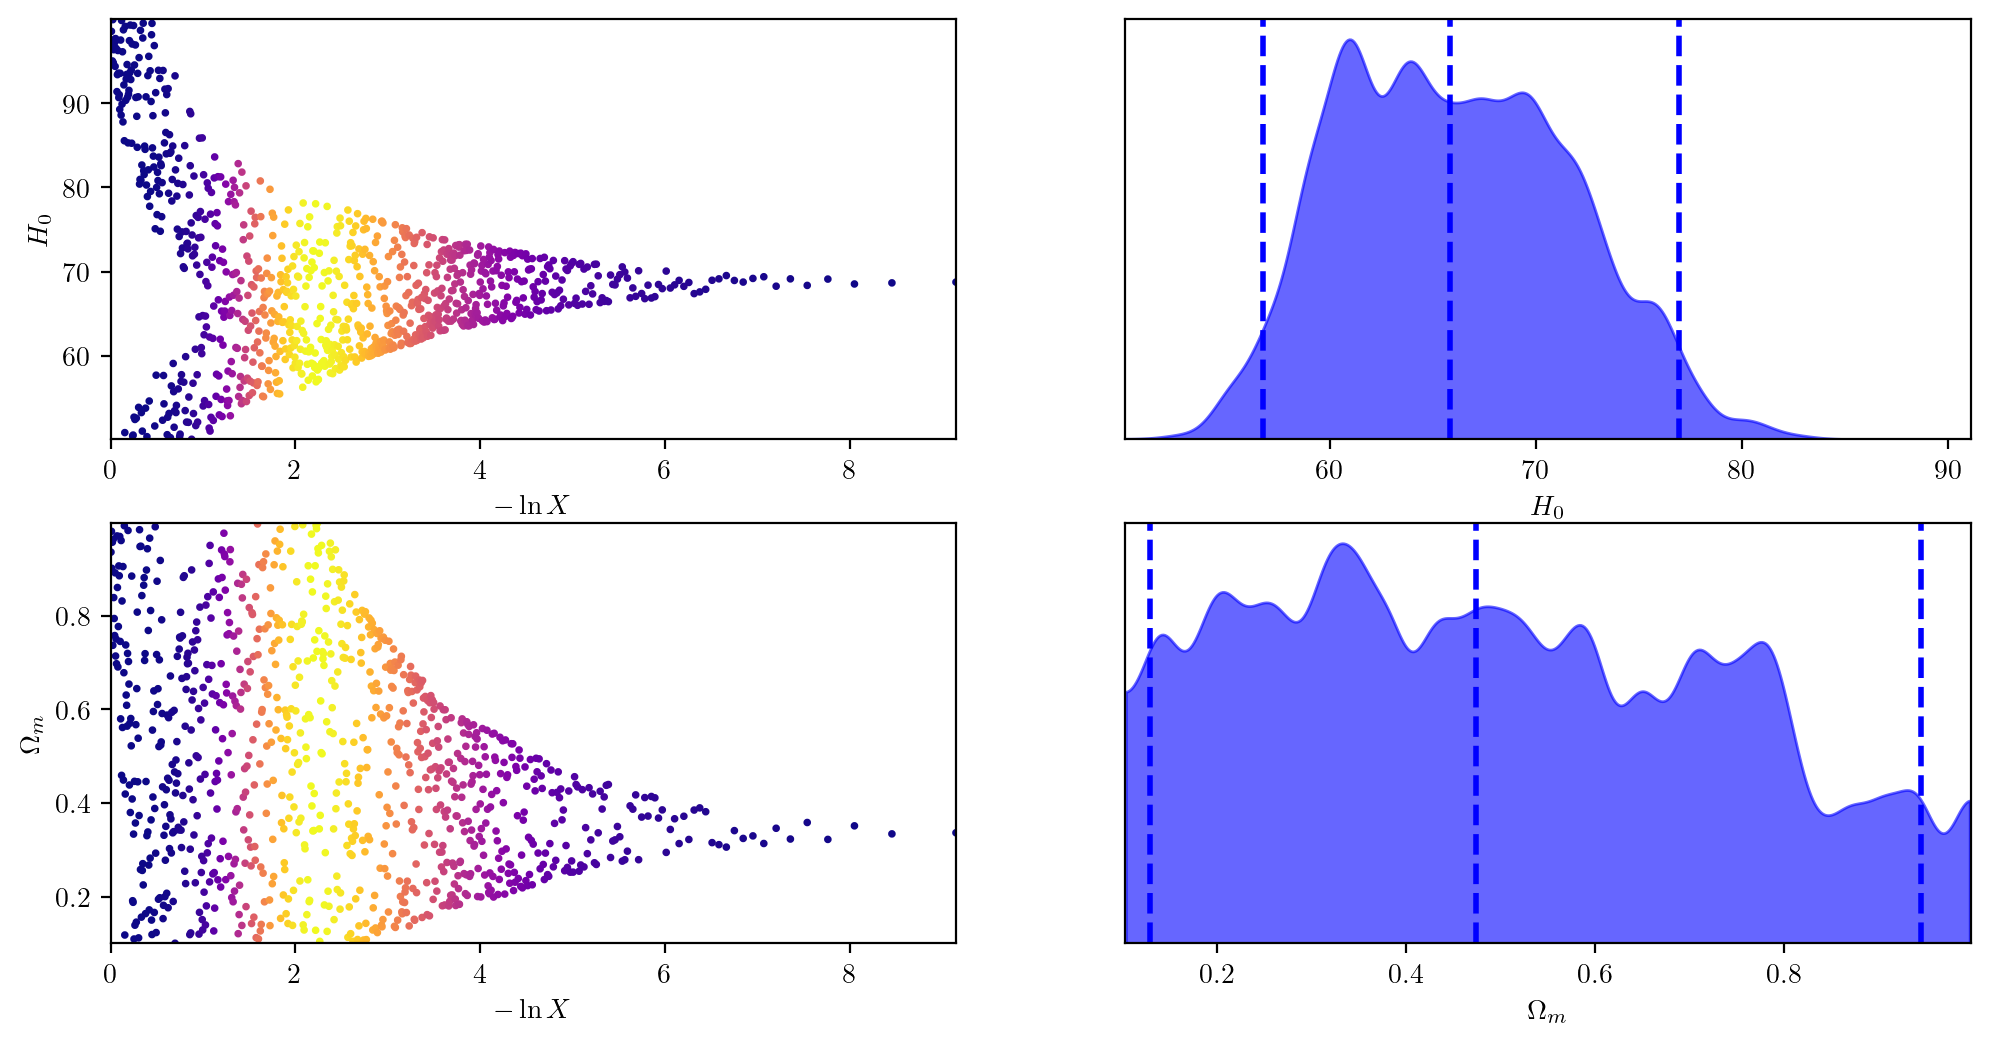

In [13]:
labels = ["$H_0$", "$\\Omega_m$"]
traceplot_fig, traceplot_axes = dyplot.traceplot(sresults, labels=labels)

#### Corner plots

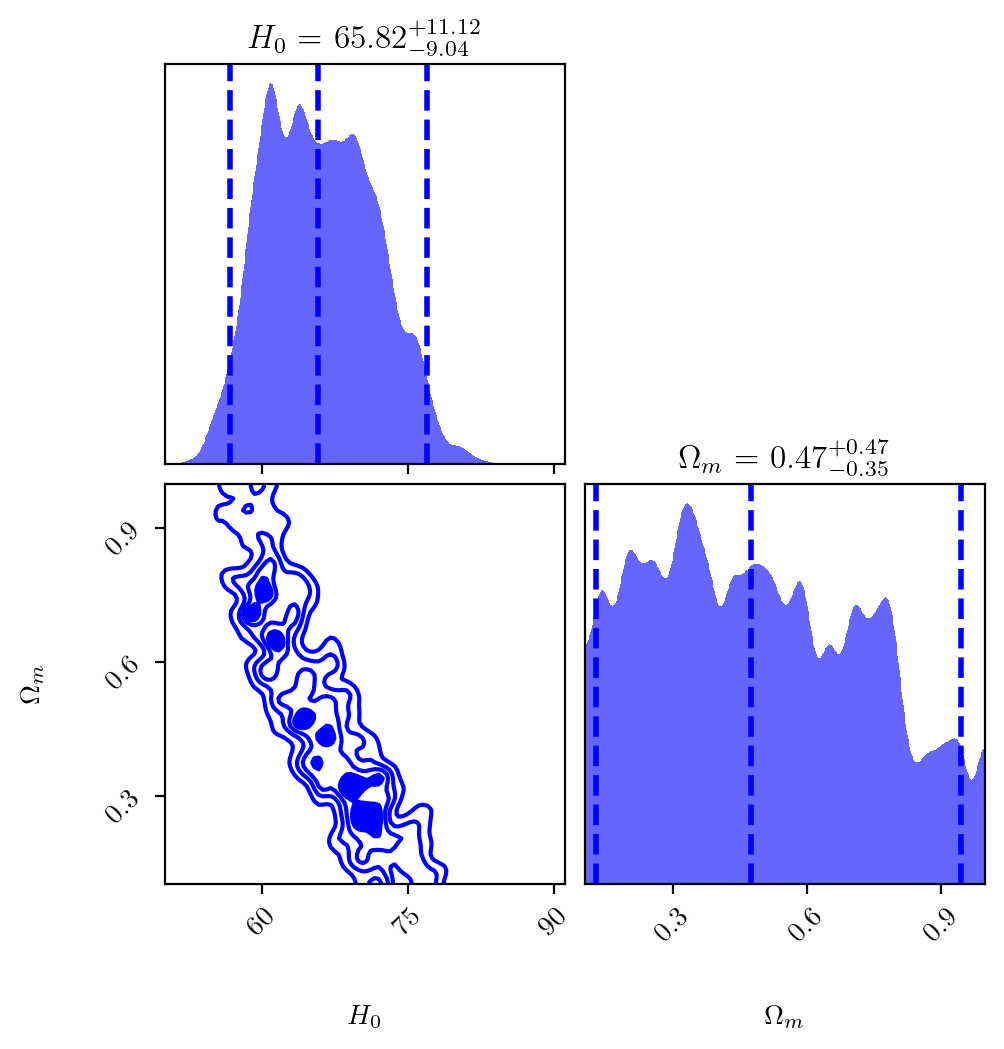

In [14]:
corner_fig, corner_axes = dyplot.cornerplot(sresults, color='b', show_titles=True, max_n_ticks=3, labels=labels)

#### Statistics

In [15]:
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

In [16]:
percentiles = [0.50, 0.16, 0.84]
quantiles = []

for sample in samples.T:
    q = dyfunc.quantile(sample, percentiles, weights=weights)
    quantiles.append(q)

quantiles = np.array(quantiles)

labels = ["H0","Om"]
print("     Median                 90% credible regions")
for i,l in enumerate(labels):
    print(l+"   "+str(quantiles[i,0])+"      "+str(quantiles[i,1])+" - "+str(quantiles[i,2]))

     Median                 90% credible regions
H0   65.81939340247264      60.310746355552546 - 72.04629625652382
Om   0.4740929415527439      0.22917515896165527 - 0.7658997281582931


In [17]:
mean, cov = dyfunc.mean_and_cov(samples, weights)

print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Mean and covariance of parameters are: [66.08393195  0.49276235]
[[31.28279912 -1.11907819]
 [-1.11907819  0.05626206]]
